# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
from scipy.signal.windows import hann

## Functions

In [2]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return p, x_


def period(x, Fs, Pmin = 1 / 300, Pmax = 1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft[1])
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax]) if Nmax > Nmin else r[Nmin:]
    I = np.argmax(r[Nmin:Nmax]) if Nmax > Nmin else np.argmax(r[Nmin:])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil if np.isscalar(corr) else (corr > seuil).all()
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [4]:
x, Fs = sf.read(file_path)

In [5]:
IPython.display.Audio(file_path)

In [6]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

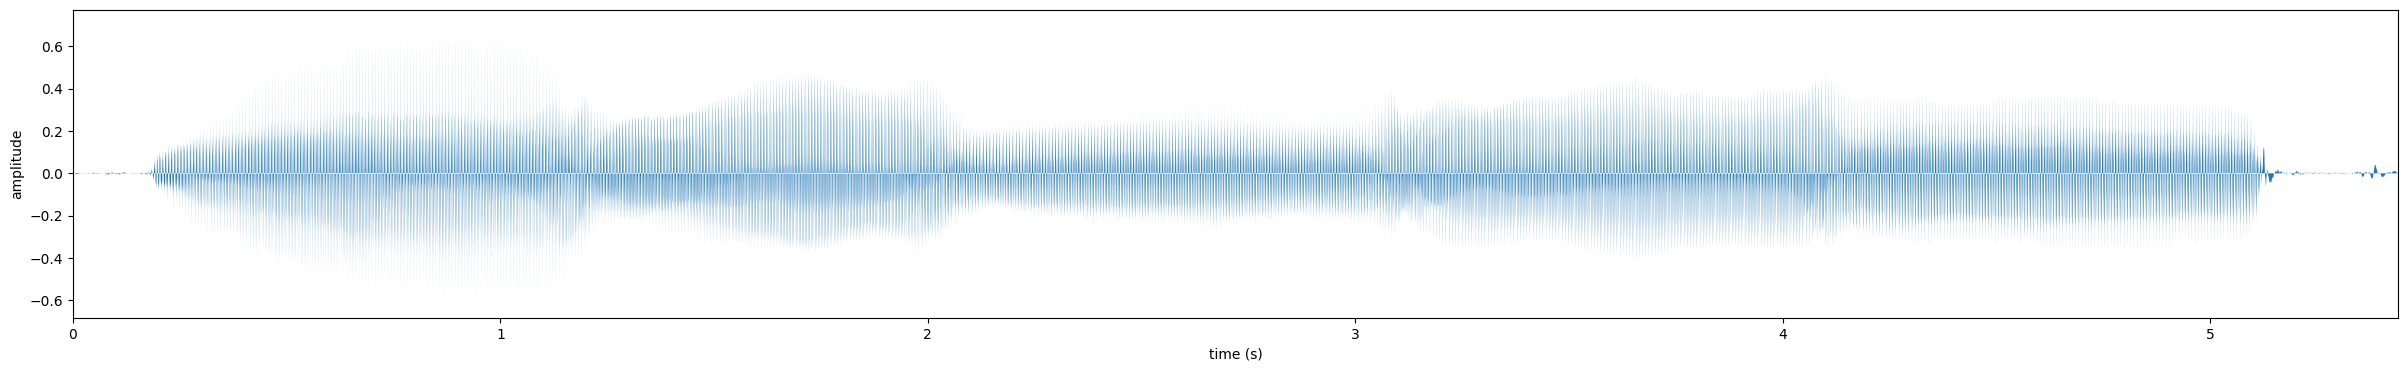

In [7]:
plot_sound(x, times)

In [8]:
sf.write('new_aeiou.wav', x, samplerate=Fs) # to write a new wave file

# PSOLA

In [9]:
audio = x.copy()
samplerate = Fs

## Analysis Pitch Marks

### Description of the Analysis Pitch Marks Function

The `AnalysisPitch Marks` function is a critical component in the process of speech signal processing, particularly in the context of Pitch Synchronous Overlap Add (PSOLA) technique used for speech modification. This function is designed to analyze an audio signal and extract pitch marks, which are crucial for understanding the periodicity and voiced characteristics of the speech.

#### **Functionality and Importance**

The function extracts analysis marks from a given speech signal. These marks are essentially time instances that correspond to significant points in the speech waveform, usually the glottal closure instants. Each mark includes information about the timing of the mark, whether the segment around the mark is voiced or unvoiced, and the pitch period (if voiced). This data is vital for subsequent processing steps like pitch shifting or time scaling, allowing for modifications while maintaining natural sounding speech.

Analysis marks are essential for modifying speech in a way that aligns modifications with the natural periodicity of the voice. Without accurate pitch marks, any modifications to pitch or duration could lead to artifacts such as robotic or unnatural sounding audio, phase discontinuities, or other distortions.

#### **Coding Approach**

The function starts by initializing key variables and preparing to iterate through the audio sample. For each cycle of the loop, the function performs the following steps:

1. **Extraction of a short-term signal segment**: A segment of the audio signal is extracted starting from the last identified pitch mark. The length of this segment is a multiple of the previously identified pitch period, ensuring that it captures a complete cycle of the waveform, which is critical for accurate pitch estimation.

2. **Pitch Estimation**: The function employs a pitch estimation technique (usually a function named `period`) to determine whether the current segment of the signal is voiced or unvoiced and to calculate the pitch period. This estimation is typically based on methods like autocorrelation or zero-crossing analysis, which can discern periodicity from the waveform characteristics.

3. **Mark Calculation and Recursion**: Based on the pitch estimation, the function calculates the next pitch mark. If the segment is voiced, the pitch mark aligns with the estimated pitch period. If unvoiced, a default period (e.g., corresponding to 10 ms) is used. This step involves careful handling of array indices and ensuring that calculations do not exceed the bounds of the audio data array.

4. **Storage and Update**: The results for each mark (time of the mark, voicing information, and pitch period) are stored in a matrix, which grows with each iteration. The function carefully manages memory and ensures efficient computation by limiting the scope of data manipulation to necessary operations.

The coding is done with particular attention to efficiency and accuracy. Handling edge cases like signal boundaries and ensuring that the pitch estimation is robust against noise and other artifacts are critical aspects of the function's implementation. The function is typically written in a high-level programming language like Python, utilizing libraries such as NumPy for efficient numerical operations, ensuring that the function can handle large datasets and perform computations quickly.

This function forms the backbone of any system designed to modify speech in meaningful ways, serving as the basis for all types of speech synthesis and modification tasks. Its ability to accurately discern and mark the phonetic characteristics of speech makes it invaluable in fields ranging from telecommunications to entertainment and assistive technologies.

In [10]:
def AnalysisPitchMarks(s, Fs):
    # Initialize analysis marks matrix A with shape (3, number_of_marks)
    # The number_of_marks is unknown beforehand, so we start with an empty list
    A = []
    
    # Initialize the first analysis mark
    ta_prev = 0  
    Pa_prev = int(10e-3 * Fs)  # 10ms * Fs as the initial period
    
    n = 0  # Start recursion index
    while ta_prev < len(s):
        # Extract a short-term signal segment from s
        start = int(ta_prev)
        end = int(start + int(2.5 * Pa_prev))
        x = s[start:end] if end <= len(s) else s[start:]
        
        # Compute period and voicing using the period function
        P, voiced = period(x, Fs)
        
        # Update the analysis marks
        A.append([ta_prev, voiced, P])
        
        # Compute next ta using recursion
        ta_prev += P
        Pa_prev = P
        
        n += 1
    
    # Convert list to numpy array with shape (3, num_marks)
    A = np.array(A).T
    return A

In [11]:
# Analyze pitch marks
A = AnalysisPitchMarks(audio, samplerate)

## Synthesis

### Description of the Synthesis Function

The `Synthesis` function plays a pivotal role in digital signal processing, particularly in the context of the Pitch Synchronous Overlap Add (PSOLA) method, which is extensively used for voice manipulation tasks such as pitch shifting and time stretching. This function is designed to reconstruct or modify a speech signal from previously extracted pitch marks, which detail the fundamental frequency and voicing characteristics of the speech.

#### **Functionality and Importance**

The `Synthesis` function is essential for generating a high-quality modified speech signal based on the analytical data derived from the original audio. The ability to manipulate pitch and duration while preserving the natural qualities of the voice is crucial for various applications, including:
- **Telecommunications**: Enhancing voice clarity or modifying the pitch to fit within certain bandwidths or to improve intelligibility.
- **Media and Entertainment**: Altering voice characteristics for artistic purposes, such as in movies, music, and gaming.
- **Assistive Technologies**: Adjusting speech outputs to accommodate different hearing profiles or to aid in language learning.

By reconstructing the speech signal based on strategic overlap and add techniques, the function ensures smooth transitions between modified segments, thereby maintaining the continuity and natural flow of the speech.

#### **Coding Approach**

The coding of the `Synthesis` function is structured to handle the complex task of reconstructing speech from discrete analysis marks with high precision and efficiency. The implementation involves several key steps:

1. **Initialization**: The function starts by determining the total length of the synthesized signal, which is calculated based on the timing of the last synthesis mark and its corresponding pitch period. This ensures that the entire duration of the original audio is accounted for in the synthesis.

2. **Buffer Creation**: An output buffer for the synthesized signal is initialized to zero. This buffer will be populated by overlapping segments of the original audio, modified as per the pitch and time scaling parameters.

3. **Overlap-Add Process**:
   - **Segment Extraction**: For each synthesis mark, the function extracts a segment from the original audio based on the corresponding analysis mark. The length of this segment typically spans the pitch period, ensuring that it captures a full cycle of the vocal waveform, which is critical for maintaining natural sound quality.
   - **Windowing**: Each extracted segment is windowed using a window function (e.g., a Hann window) to smooth the edges. This step is crucial to minimize artifacts such as clicking sounds at the boundaries of overlapped segments.
   - **Overlap-Add**: The windowed segments are then added into the output buffer at positions determined by the synthesis marks. The overlap-add technique ensures that the segments blend smoothly into one another, preserving the continuity of the speech waveform.

4. **Handling Edge Cases**: The function includes logic to handle edge cases, such as boundaries of the audio file where segments might extend beyond the available data. It carefully manages these cases to avoid buffer overflows and ensures that every segment fits perfectly within the output buffer.

5. **Final Output**: The populated buffer, now containing the synthesized speech signal, is finalized and made ready for playback or further processing.

This approach ensures that the `Synthesis` function can effectively modify speech while maintaining its natural timbre and intonation, making it a critical tool in modern digital audio processing.

In [12]:
def Synthesis(s, Fs, A, B):
    # Check the array types and shapes
    if not isinstance(A, np.ndarray) or not isinstance(B, np.ndarray):
        raise ValueError("A and B must be numpy arrays")
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("A and B must be 2-dimensional arrays")

    # Initialize the synthesis signal y
    kend = B.shape[1] - 1  # Accessing the last column safely
    if kend < 0:
        raise ValueError("B has no columns")

    # Properly accessing the last elements in B
    ts_kend = B[0, kend].astype(int)  # time index in the last column of B
    an_kend = B[1, kend].astype(int) - 1  # adjusting MATLAB-style 1-based index to Python's 0-based index

    if an_kend >= A.shape[1] or an_kend < 0:
        raise ValueError("Index out of bounds for array A")

    # Calculate y_length safely
    y_length = int(ts_kend + A[2, an_kend])
    y = np.zeros(y_length)
    
    # Perform synthesis by recursion on k >= 1
    for k in range(len(B[0])):
        n_k = B[1, k].astype(int) - 1  # Convert 1-based index to 0-based
        t_s_k = int(B[0, k])
        t_a_n_k = int(A[0, n_k])
        P_a_n_k = int(A[2, n_k])
        
        # Extract a sequence x centered at t_a(n(k)) of length 2*P_a(n(k)) + 1
        x_start = max(t_a_n_k - P_a_n_k, 0)
        x_end = min(t_a_n_k + P_a_n_k + 1, len(s))
        x = s[x_start:x_end]
        
        # Apply a Hann window to the sequence x
        window = hann(len(x))
        x_windowed = x * window
        
        # Overlap-add the windowed sequence x into the synthesis signal y
        y_start = max(t_s_k - P_a_n_k, 0)
        y_end = min(t_s_k + P_a_n_k + 1, len(y))
        
        # Since x_windowed can be smaller than the range in y due to signal boundaries,
        # we calculate the actual start indices for overlap-adding
        y_range = y_end - y_start
        x_range = min(len(x_windowed), y_range)
        y[y_start:y_start + x_range] += x_windowed[:x_range]
    
    return y

In [13]:
# Perform simple synthesis without modification
B_simple = np.vstack((A[0, :], np.arange(1, A.shape[1] + 1)))  # B without modification
synthesized_audio = Synthesis(audio, samplerate, A, B_simple)

# Save synthesized audio for playback
output_path = 'synthesized_audio.wav'
sf.write(output_path, synthesized_audio, samplerate)

# Play synthesized audio
print("Synthesized Audio (No Modification):")
IPython.display.Audio(output_path)

Synthesized Audio (No Modification):


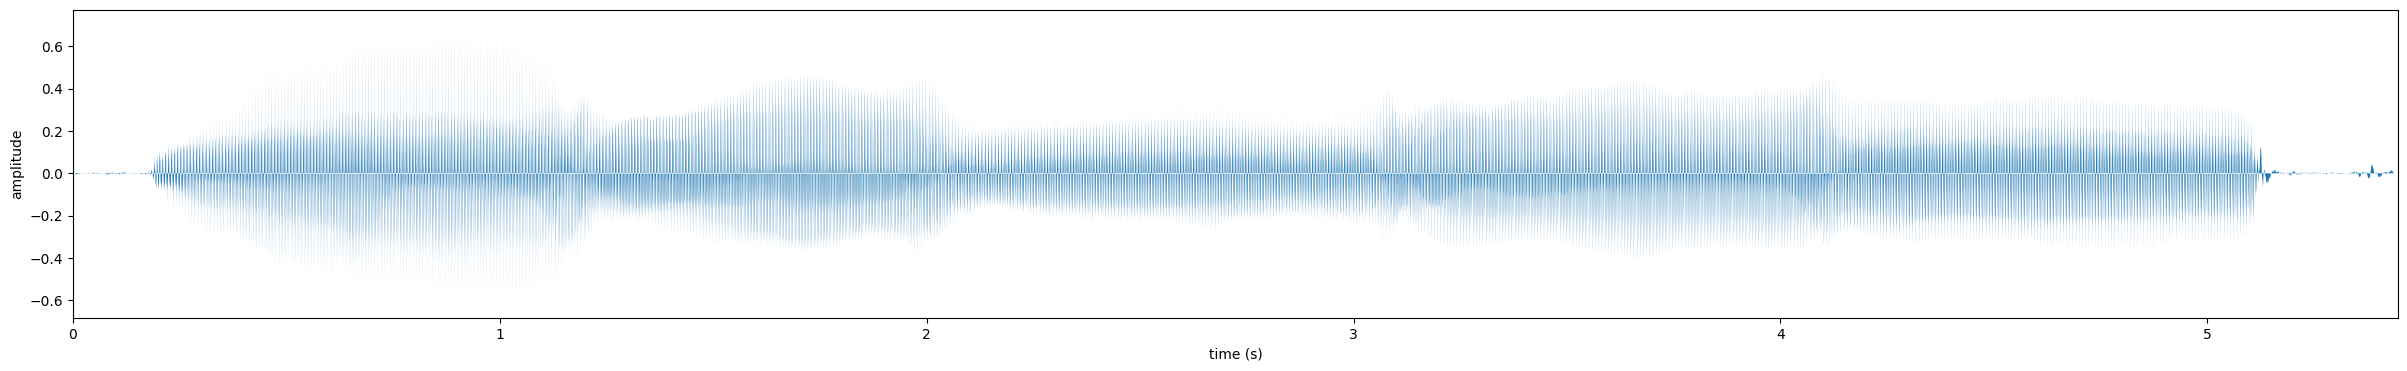

In [21]:
x, Fs = sf.read(output_path)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

## Change Time Scale

### Description of the ChangeTimeScale Function

The `ChangeTimeScale` function is a vital component in speech processing, particularly when implementing the Pitch Synchronous Overlap Add (PSOLA) method for time-scaling speech signals. This function adjusts the temporal characteristics of a speech signal, allowing for the stretching or compressing of the audio without significantly altering the pitch.

#### **Functionality and Importance**

The `ChangeTimeScale` function adjusts the speed of spoken content while aiming to preserve the naturalness and intelligibility of the speech. This capability is essential for various applications including:
- **Educational tools**: Slowing down speech to help language learners understand pronunciation and intonation more clearly.
- **Accessibility features**: Adjusting speech tempo for audiobooks or communication aids for those with hearing impairments or processing disorders.
- **Media post-production**: Speeding up or slowing down dialogue to match video content or to fit specific time slots without affecting the pitch of the speaker's voice.

By manipulating the time scale of speech signals, the function facilitates a wide range of audio editing and processing tasks, enhancing both the flexibility and usability of audio content across different contexts and user needs.

#### **Coding Approach**

The coding of the `ChangeTimeScale` function involves several critical steps to ensure accurate and effective time scaling of audio signals:

1. **Initialization**: The function starts by creating initial time and index arrays, `ts` and `n`, which store the new timing marks for synthesis and the corresponding indices from the original signal's analysis marks.

2. **Temporal Adjustment Through Recursion**:
   - **Loop Mechanics**: The function iterates over each analysis mark, applying a scaling factor to adjust the spacing between consecutive synthesis marks. This loop continues until it has processed all relevant analysis marks or reaches the end of the audio data.
   - **Time Scaling Calculation**: For each iteration, the function calculates the next synthesis mark based on the scaled interval from the previous mark. The scaling factor (alpha) determines how much to stretch or compress the audio; values greater than one slow down the audio, while values less than one speed it up.

3. **Index Calculation**:
   - **Non-integer Handling**: Since the synthesis marks may not align with integer indices due to non-integer scaling factors, the function carefully rounds or interpolates indices to ensure they reference valid points in the analysis data.
   - **Index Progression**: The function increments the index array based on the scaling factor, ensuring that each new synthesis mark references the appropriate corresponding analysis mark. This careful management of indices is crucial for maintaining synchrony between the original and scaled audio.

4. **Output Preparation**:
   - **Matrix Assembly**: The function compiles the calculated time and index arrays into a matrix `B`, which is then used by the synthesis function to generate the time-scaled audio. This matrix must be accurately constructed to ensure that the synthesis process can correctly interpret and apply the new timing data.

5. **Edge Cases and Validation**:
   - **Boundary Checks**: The function includes checks to ensure that calculated indices do not exceed the bounds of the input data, preventing runtime errors and ensuring robust operation across a variety of input lengths and scaling factors.

The `ChangeTimeScale` function's implementation emphasizes precision in recalculating timing marks and robust handling of edge cases, ensuring that time-scaled audio remains synchronized and natural-sounding. This meticulous approach is what makes the function indispensable for professional-grade audio processing tasks.

In [14]:
def ChangeTimeScale(alpha, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 (initializing at 1 for MATLAB compatibility if needed)
    n = [1]   # Start with n(1) = 1
    
    # Fill matrix B by adjusting ts and n based on factor alpha
    k = 0
    while True:
        current_n = int(np.floor(n[k]))  # Use floor to ensure we use an integer index for n
        if current_n >= len(A[0]):
            break  # Stop if the index exceeds the number of available analysis marks
        
        # Calculate the next ts(k)
        if k == 0:
            next_ts = ts[k]  # Initialize ts(0)
        else:
            next_ts = ts[k - 1] + int(A[2, current_n - 1])  # Pa(n[k]) where n[k] is 1-based

        # Append the calculated ts to the ts list
        ts.append(next_ts)
        
        # Calculate the next n(k)
        next_n = n[k] + 1/alpha
        n.append(next_n)
        
        k += 1  # Increment k for the next iteration
    
    # Convert ts and n to integer values suitable for indexing (adjusting for 1-based indexing if needed)
    ts = [int(t) for t in ts]
    n = [int(np.floor(nk)) for nk in n]
    
    # Ensure that indices in n are within the valid range of analysis marks
    n = [ni if ni < len(A[0]) else len(A[0]) for ni in n]
    
    # Stack ts and n to form matrix B
    B = np.array([ts[:-1], n[:-1]])  # Remove the last element to prevent out-of-bounds indexing

    return B


In [15]:
# Apply time scaling
alpha = 0.8  # Scaling factor for time (slow down the signal)
B_time_scaled = ChangeTimeScale(alpha, A, samplerate)
time_scaled_audio = Synthesis(audio, samplerate, A, B_time_scaled)

# Save time-scaled audio for playback
time_scaled_output_path = 'time_scaled_audio.wav'
sf.write(time_scaled_output_path, time_scaled_audio, samplerate)

# Display the time-scaled audio
print("Time-Scaled Audio:")
IPython.display.Audio(time_scaled_output_path)

Time-Scaled Audio:


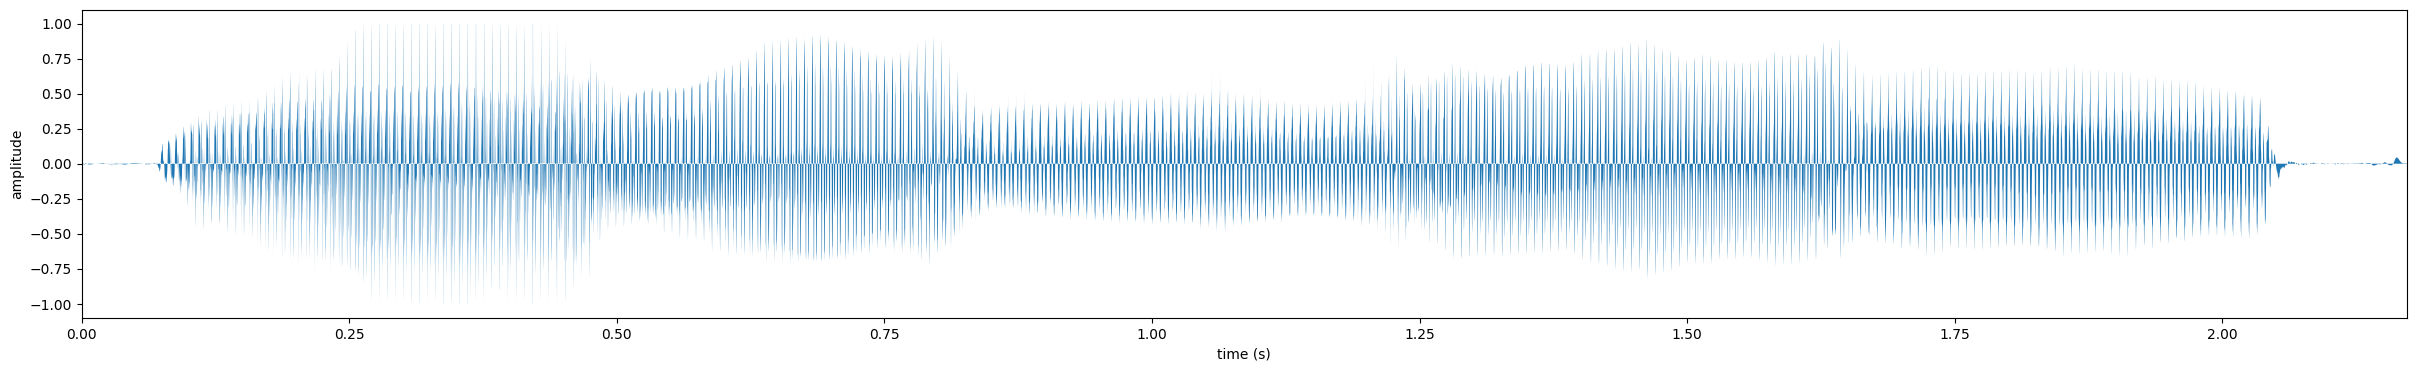

In [22]:
x, Fs = sf.read(time_scaled_output_path)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

# Chage Pitch Scale

### Description of the ChangePitchScale Function

The `ChangePitchScale` function is an integral part of speech processing, particularly in the context of the Pitch Synchronous Overlap Add (PSOLA) technique used for manipulating the pitch of speech signals. This function modifies the fundamental frequency of the speech signal, allowing the pitch to be adjusted up or down without altering the tempo.

#### **Functionality and Importance**

The `ChangePitchScale` function is designed to alter the pitch of a speech signal, which can be crucial for a variety of applications:
- **Voice modification**: Adjusting the pitch to change perceived characteristics of a voice, such as making it sound deeper or higher for artistic or entertainment purposes.
- **Language learning tools**: Modifying the pitch to help non-native speakers better understand linguistic nuances.
- **Accessibility features**: Adapting the pitch for different hearing profiles, making speech easier to understand for those with hearing impairments.

Adjusting the pitch is important not only for altering the auditory aesthetics of speech but also for fitting speech into different contexts or making it more accessible.

#### **Coding Approach**

The coding of the `ChangePitchScale` function involves precise calculations and iterations to ensure accurate pitch modifications while maintaining the natural flow of the speech. Here’s how the function is structured:

1. **Initialization**:
   - **Starting Points**: The function initializes arrays `ts` (time stamps for synthesis) and `n` (indices referencing analysis marks) based on the input analysis matrix `A`.
   - **Loop Setup**: Iterates through each analysis mark to adjust the timing and indexing based on the pitch scaling factor `beta`.

2. **Pitch Scaling Logic**:
   - **Voiced and Unvoiced Segments**: The function differentiates between voiced and unvoiced segments of speech. Voiced segments are directly affected by the pitch scaling factor, whereas unvoiced segments are typically not altered since they do not have a harmonic structure that pitch scaling would affect.
   - **Scale Application**: For voiced segments, the function calculates a scaling factor for the pitch period (from `A`), applying `1/beta` if increasing pitch or `beta` if decreasing pitch. This adjusts how quickly synthesis marks are placed relative to each other, effectively changing the frequency of the waveforms being generated.

3. **Synthesis Mark Calculation**:
   - **Time Calculation**: Adjusts the time stamp for each synthesis mark based on the scaled pitch period. This ensures that each segment of the synthesized speech matches the new pitch.
   - **Index Increment**: Carefully increments the reference index `n`, taking into account the scaling to ensure that each new synthesis mark correctly references the pitch-adjusted segments.

4. **Handling Edge Cases**:
   - **Rounding and Interpolation**: Since the scaling can result in non-integer values for indices and time stamps, the function rounds or interpolates these values to ensure they reference valid points in the analysis data.
   - **Boundary Conditions**: Includes checks to ensure that indices do not exceed the data bounds, preventing errors that could arise from referencing outside the available data range.

5. **Output Preparation**:
   - **Matrix Construction**: Assembles the adjusted time stamps and indices into a matrix `B`, which is used by the synthesis function to reconstruct the audio with the adjusted pitch. This matrix must be accurately constructed to ensure correct interpretation during synthesis.

The `ChangePitchScale` function's implementation highlights a balance between mathematical precision and practical application, ensuring that pitch modifications are both perceptible and natural-sounding. This meticulous approach is crucial for delivering professional-grade audio processing capabilities, suitable for both commercial applications and research in digital signal processing.

In [16]:
def ChangePitchScale(beta, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 for simplicity (assuming start at sample index 1 for clarity)
    n = [1]   # Start with n(1) = 1 assuming 1-based index as input

    # Fill matrix B by adjusting ts and n based on pitch scaling factor beta
    k = 0
    while k < A.shape[1] - 1:  # Ensure we do not go out of bounds
        current_n = int(n[k] - 1)  # Adjusting for 0-based index in Python
        if current_n >= A.shape[1]:
            break  # Stop if the index exceeds the number of available analysis marks

        # Calculate scale based on voiced or unvoiced
        if A[1, current_n] == 1:  # Assuming A[1, n] indicates voiced (1) or unvoiced (0)
            scale = 1 / beta
        else:
            scale = 1

        # Calculate the next ts(k)
        next_ts = ts[k] + scale * A[2, current_n]  # Pa(n(k)) scaled by the factor
        ts.append(int(next_ts))  # Store integer values in B

        # Calculate the next n(k)
        next_n = n[k] + scale
        n.append(next_n)

        k += 1  # Increment k for the next iteration

    # Stack ts and n to form matrix B, ensuring all indices are integers
    B = np.array([ts[:-1], [int(round(ni)) for ni in n[:-1]]])  # Remove the last element to prevent out-of-bounds indexing

    return B

In [17]:
# Apply pitch scaling with a chosen beta factor
beta = 1.2  # Example factor to decrease pitch
B_pitch_scaled = ChangePitchScale(beta, A, samplerate)
pitch_scaled_audio = Synthesis(audio, samplerate, A, B_pitch_scaled)

# Save time and pitch scaled audio for playback
pitch_scaled_output_path = 'pitch_scaled_audio.wav'
sf.write(pitch_scaled_output_path, pitch_scaled_audio, samplerate)

# Display the time-scaled audio
print("Time-Scaled Audio:")
IPython.display.Audio(pitch_scaled_output_path)


Time-Scaled Audio:


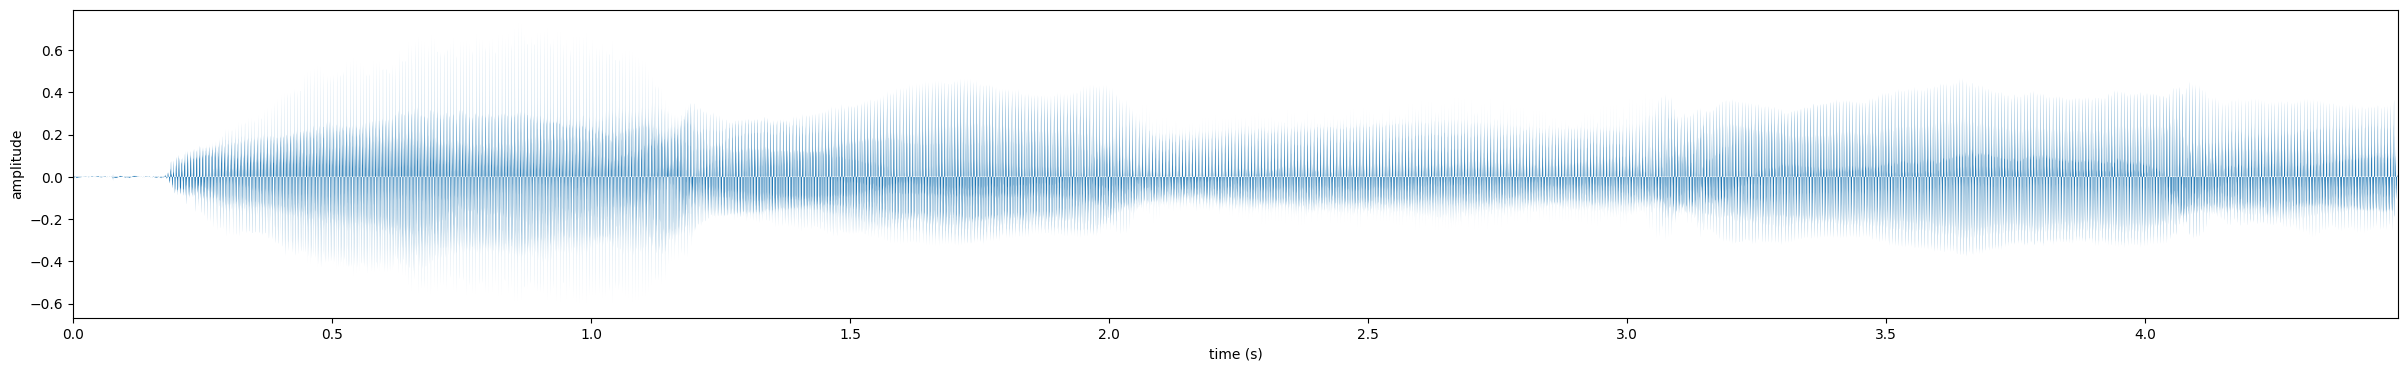

In [23]:
x, Fs = sf.read(pitch_scaled_output_path)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

## Change Both Scales

### Description of the ChangeBothScales Function

The `ChangeBothScales` function is an essential tool in the domain of digital speech processing, specifically within the framework of Pitch Synchronous Overlap Add (PSOLA) techniques. This function simultaneously adjusts both the temporal and spectral characteristics of speech signals. It allows for the modification of speech in terms of its duration and pitch, which can be critical for a variety of applications ranging from entertainment to assistive technologies.

#### **Functionality and Importance**

The `ChangeBothScales` function serves a dual purpose by allowing changes to both the time scale and pitch of a speech signal:
- **Media Production**: Enables precise control over speech characteristics to fit specific time slots or to match emotional tones in video content.
- **Accessibility**: Adjusts speech signals to accommodate specific listener needs, such as slowing down speech while maintaining a natural pitch for listeners with auditory processing challenges.
- **Language Learning**: Helps learners by modifying the speed and pitch of language lessons to enhance clarity and comprehension.

This dual functionality is particularly valuable because it provides comprehensive control over speech signals, enabling more nuanced modifications without compromising the natural quality of the original recording.

#### **Coding Approach**

The coding of the `ChangeBothScales` function involves a series of calculated steps to ensure that changes to speech are synchronized and maintain the fluidity of the speech signal:

1. **Initialization**:
   - **Starting Points**: Arrays `ts` (time stamps) and `n` (index references) are initialized based on the first analysis mark.
   - **Parameters Setup**: Accepts `alpha` for time scaling and `beta` for pitch scaling as inputs, influencing how the speech duration and pitch are modified.

2. **Combined Scaling Logic**:
   - **Iterative Adjustment**: Processes each analysis mark to adjust both the timing and pitch. The loop iterates over the indices, applying the scaling factors to modify how synthesis marks are spaced and how pitch periods are calculated.
   - **Voiced/Unvoiced Differentiation**: The function applies pitch scaling only to voiced segments of speech, as unvoiced segments lack a harmonic structure and typically do not undergo pitch adjustments. The time scaling, however, affects both voiced and unvoiced segments.

3. **Synthesis Mark and Index Calculation**:
   - **Time Stamp Calculation**: Each new synthesis time stamp (`ts`) is calculated by adding the scaled pitch period to the previous mark. The scale for pitch is adjusted by `1/beta` if the segment is voiced, affecting how quickly subsequent marks are placed.
   - **Index Incrementation**: The index increment (`n`) is adjusted by `alpha`, accounting for the time scaling, to ensure the spacing between indices matches the desired temporal modification.

4. **Handling Edge Cases**:
   - **Rounding and Validating Indices**: Ensures that all calculated indices and time stamps are rounded to integer values and remain within the valid range of the original data. This step is crucial to avoid referencing outside the bounds of the data array, which could lead to errors during synthesis.
   - **Boundary Checks**: Includes checks to prevent overflows and ensure that the function does not attempt to access data beyond the end of the array.

5. **Output Matrix Assembly**:
   - **Matrix Construction**: The function compiles the calculated time stamps and indices into matrix `B`, structured to guide the synthesis process in reconstructing the audio with the new time and pitch settings.

The `ChangeBothScales` function's sophisticated integration of both pitch and time modifications allows for flexible and dynamic speech manipulation. This function is crucial for professionals who need to adjust audio properties without compromising the coherence and quality of speech, ensuring that the output remains usable and effective for its intended purpose.

In [18]:
def ChangeBothScales(alpha, beta, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 (initializing at 1 for MATLAB compatibility if needed)
    n = [1]   # Start with n(1) = 1
    
    # Fill matrix B by adjusting ts and n based on factors alpha and beta
    k = 0
    while True:
        current_n = int(np.floor(n[k]))  # Use floor to ensure we use an integer index for n
        if current_n >= len(A[0]):
            break  # Stop if the index exceeds the number of available analysis marks
        
        # Calculate the next ts(k) with consideration of beta for pitch scaling
        if k == 0:
            next_ts = ts[k]  # Initialize ts(0)
        else:
            current_pitch = int(A[2, current_n - 1])  # Pa(n[k]) where n[k] is 1-based
            scaled_pitch = int(current_pitch / beta)  # Adjust pitch period by beta
            next_ts = ts[k - 1] + scaled_pitch  # Adjust timing using the scaled pitch
        
        # Append the calculated ts to the ts list
        ts.append(next_ts)
        
        # Calculate the next n(k) adjusted by alpha for time scaling
        next_n = n[k] + (1 / alpha)
        n.append(next_n)
        
        k += 1  # Increment k for the next iteration
    
    # Convert ts and n to integer values suitable for indexing (adjusting for 1-based indexing if needed)
    ts = [int(t) for t in ts]
    n = [int(np.floor(nk)) for nk in n]
    
    # Ensure that indices in n are within the valid range of analysis marks
    n = [ni if ni < len(A[0]) else len(A[0]) for ni in n]
    
    # Stack ts and n to form matrix B
    B = np.array([ts[:-1], n[:-1]])  # Remove the last element to prevent out-of-bounds indexing

    return B

In [19]:
# Apply both time and pitch scaling
alpha = 0.8  # Scaling factor for time
beta = 1.2   # Scaling factor for pitch
B_both_scaled = ChangeBothScales(alpha, beta, A, samplerate)
both_scaled_audio = Synthesis(audio, samplerate, A, B_both_scaled)

# Save time and pitch scaled audio for playback
both_scaled_output_path = 'both_scaled_audio.wav'
sf.write(both_scaled_output_path, both_scaled_audio, samplerate)

# Play time and pitch scaled audio
print("Time and Pitch Scaled Audio:")
IPython.display.Audio(both_scaled_output_path)

Time and Pitch Scaled Audio:


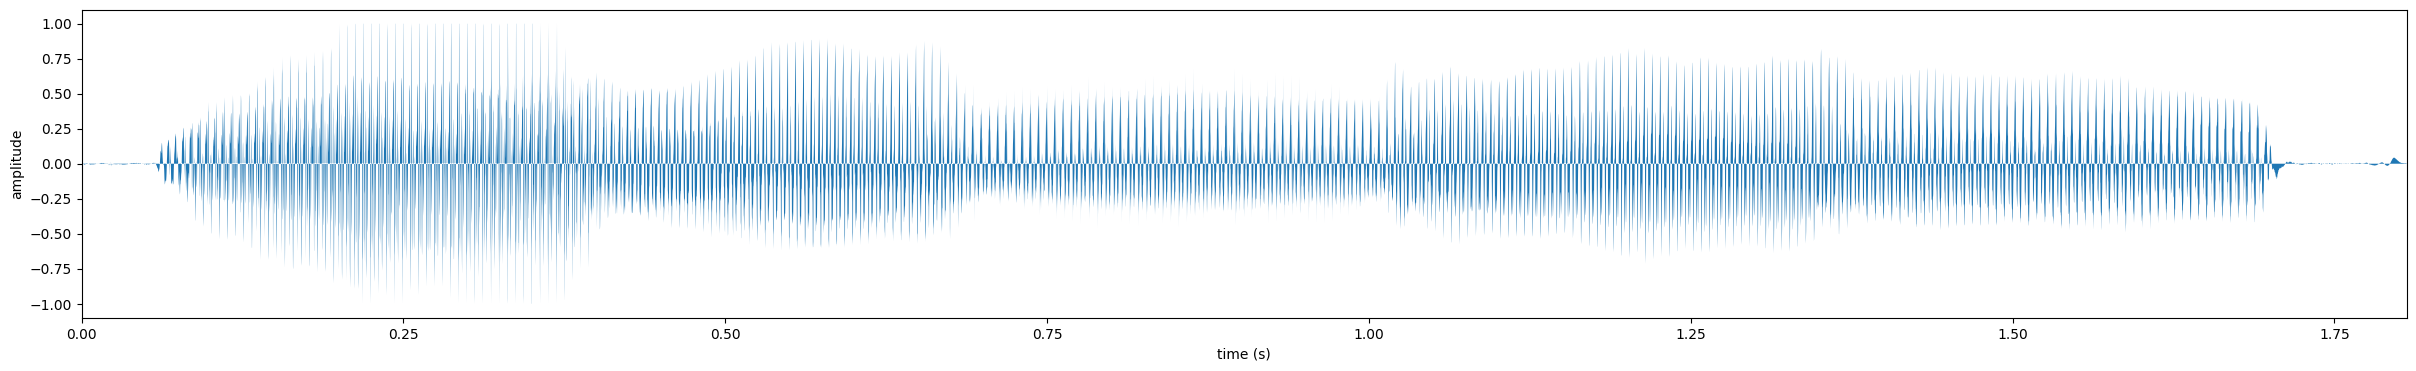

In [24]:
x, Fs = sf.read(both_scaled_output_path)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)